In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchvision.transforms import functional as Fun
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
import time
from typing import Iterable
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [15]:
class KenyanFood13Dataset(Dataset):
    
    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        
        # get label to species mapping
        label_csv_path = os.path.join(data_root, 'train.csv')
        self.label_df = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        
        cls_find = True
        self.cls_label = [self.label_df['class'][0]]
        #print('cls_label=', self.cls_label)

        # initialize the data dictionary
        full_data_dict = {
            'image_path': [],
            'label': []
        }
        # loop for identifying number of types of food
        for i in range (1, len(self.label_df)):
            num_classes = True
            for j in range (len(self.cls_label)):
                #matching the class names to collect the class names
                if(self.cls_label[j] == self.label_df['class'][i]):
                    num_classes = False
            if (num_classes):
                self.cls_label.append(self.label_df['class'][i])
                
        num_classes = len(self.cls_label)

        #Printing the total number of classes
        #print("len(self.cls_label)=", len(self.cls_label))
        #for j in range (len(self.cls_label)):
            #print(self.cls_label[j])      
            
        # loop for identifying number / types of food
        #for i in range (0, len(self.label_df)):
            #if (self.label_df['class'][i] == self.cls_label[i])
    
    
        type_hist = np.zeros(num_classes)
        
        img_dir = os.path.join(data_root, 'images', 'images')        
        for i in range(len(self.label_df)):
            img_id = self.label_df['id'][i]
            img_path = os.path.join(img_dir, '{}'.format(img_id))
            img_path = img_path +'.jpg'
            for j in range (num_classes):
                if (self.label_df['class'][i] == self.cls_label[j]):
                    cls_id = j
            type_hist[cls_id] += +1
            full_data_dict['image_path'].append(img_path)
            full_data_dict['label'].append(cls_id)           
        
        #print('type_hist=', type_hist)
        train_hist = np.round (type_hist* 0.8)
        #print('train_hist=', train_hist)
        valid_hist = type_hist - train_hist
        #print('valid_hist=', valid_hist)
        
        tr_data_dict = {
            'image_path': [],
            'label': []
        }
        val_data_dict = {
            'image_path': [],
            'label': []
        }
        indexing = np.zeros(num_classes)
        for i in range(len(self.label_df)):
            img_path = full_data_dict['image_path'][i]        
            label = full_data_dict['label'][i]     
            indexing[label] += 1
            #print('indexing: {}, train_hist: {}'.format(indexing[label], train_hist[label]))
            if(indexing[label] <= train_hist[label]):
                tr_data_dict['image_path'].append(img_path)
                tr_data_dict['label'].append(label)     
            elif(indexing[label] > train_hist[label]):
                val_data_dict['image_path'].append(img_path)
                val_data_dict['label'].append(label)   
        
        #print('length tr_data_dict=', len(tr_data_dict['label']))
        #print('length val_data_dict=', len(val_data_dict['label']))    
      
        # loading data according to the validation or training set    
        if(train == True):
            self.data_dict = tr_data_dict
        else:
            self.data_dict = val_data_dict
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
                
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform
                    
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])        
                
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        #print('path from getitem')
        #print(self.data_dict['image_path'][idx])
        
        if self.image_shape is not None:
            image = Fun.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]
        
        return image, target   
    
    def food_class(self, label):
        """
        class label to common name mapping
        """
        return self.cls_label[label]
    


Length of the train_dataset: 5228
Label: 12, Food class: mukimo


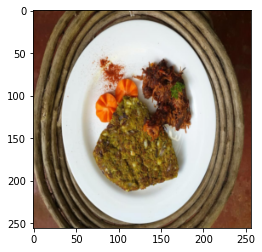

In [16]:
# data root directory
data_root = '/kaggle/input/pytorch-opencv-course-classification'

train_dataset =  KenyanFood13Dataset(data_root, train=True, image_shape=256 )
print('Length of the train_dataset: {}'.format(len(train_dataset)))

img, trgt = train_dataset[5220]

print('Label: {}, Food class: {}'.format(trgt, train_dataset.food_class(trgt)))

plt.imshow(img)
plt.show()


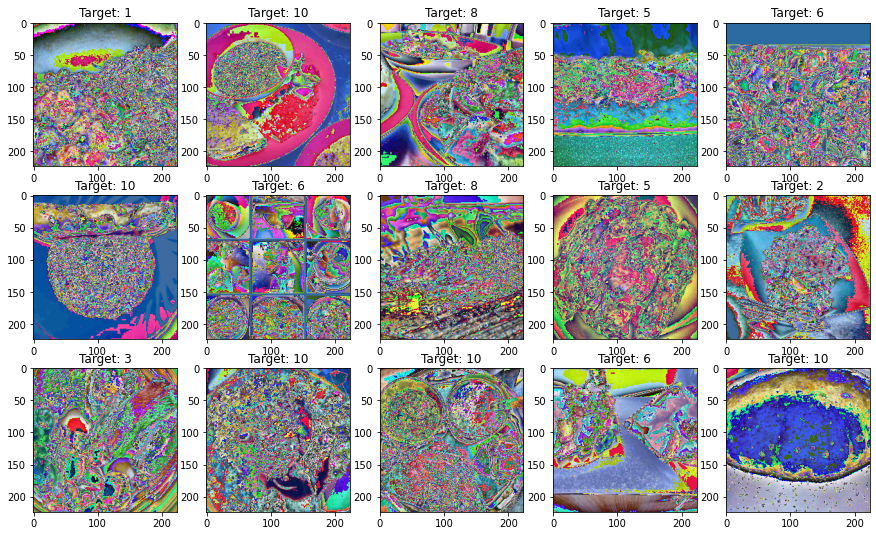

In [17]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

def image_common_transforms(mean, std):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

  
def get_mean_std():
    
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    return mean, std

"""       
    loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=2
    )

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
"""
    

def data_augmentation_preprocess(mean, std):
    print('data augmentation called')
    train_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(10),
        ]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return train_transforms

def get_data(data_root, batch_size, num_workers=4, data_augmentation=False):
     
    transform = image_preprocess_transforms()
    mean, std = get_mean_std()
    common_transforms = image_common_transforms(mean, std)
    
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
    
    valid_transform = image_common_transforms(mean, std)
    train_dataset =  KenyanFood13Dataset(data_root, train=True, image_shape=None, transform=train_transforms)
    test_dataset =  KenyanFood13Dataset(data_root, train=False, image_shape=None, transform=valid_transform)
    
    train_loader = torch.utils.data.DataLoader( train_dataset, batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader( test_dataset, batch_size, shuffle=True, num_workers=2)
    
    return train_loader, test_loader


train_loader, test_loader = get_data(data_root, batch_size=16, num_workers=4, data_augmentation=False)

# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in train_loader:
    for i in range(15):
        plt.subplot(3, 5, i+1)
        img = Fun.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break
    

In [18]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)


@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  
    epochs_count: int = 40 
    init_learning_rate: float = 0.002  # initial learning rate for lr scheduler
    decay_rate: float = 0.1  
    log_interval: int = 500  
    test_interval: int = 1  
    data_root: str = '/kaggle/input/pytorch-opencv-course-classification' 
    num_workers: int = 10  
    device: str = 'cuda'

In [19]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic


def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
        
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:

            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc


def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

def save_model(model, device, model_dir='models', model_file_name='kenya_food_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict 
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

def main(model, optimizer, tb_writer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
        print("cuda found")
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
             
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )
        
        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
                
        # scheduler step/ update learning rate
        if scheduler is not None:
            scheduler.step(current_loss)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc



In [20]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.SGD( model.parameters(), lr = init_learning_rate, momentum = 0.9)
    
    """
    optimizer = optim.Adam( model.parameters(), lr = train_config.init_learning_rate)
    decay_rate = train_config.decay_rate
    lmbda = lambda epoch: 1/(1 + decay_rate * epoch)
    """

    # Scheduler
    #scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    return optimizer, scheduler

In [21]:
def pretrained_resnet(transfer_learning=False, num_class=13):
    #resnet = models.resnet18(pretrained=True)
    #resnet = models.resnext50_32x4d(pretrained=True)
    #resnet = models.inception_v3(pretrained=True)
    #resnet = models.resnext101_32x8d(pretrained=True)
    resnet = models.resnet152(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
    """        
    model = models.resnext50_32x4d(pretrained=True) 
    for param in model.parameters(): 
        param.requires_grad = False
    for param in model.layer4: 
        param.requires_grad = True
    
    num_ftrs = model.fc.in_features   
    model.fc = nn.Linear(num_ftrs, 13)
    """ 
     
    last_layer_in = resnet.fc.in_features
    #4096 for vgg11
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet

In [ ]:
# training starts here
####*** FINE TUNING ***####

model = pretrained_resnet(transfer_learning=False)
print(model)
# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Tensorboard summary writer
fine_tuning_sw = SummaryWriter('KenyaFood-resNext50/fine_tuning')   
model, train_loss, train_acc, val_loss, val_acc = main(model, 
                                                       optimizer,
                                                       fine_tuning_sw,
                                                       scheduler,
                                                       data_augmentation=True)

#fine_tuning_sw.close()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch: 0 
Train Loss: 1.372887 Acc: 0.5681
Elapsed 135.43s, 135.43 s/epoch, 0.41 s/batch, ets 5281.60s

Test set: Average loss: 0.9736, Accuracy: 912/1308 (70%)

Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 0.903906 Acc: 0.7104
Elapsed 301.76s, 150.88 s/epoch, 0.46 s/batch, ets 5733.44s

Test set: Average loss: 0.9524, Accuracy: 933/1308 (71%)

Model Improved. Saving the Model...

Epoch: 2 
Train Loss: 0.635121 Acc: 0.7952
Elapsed 468.38s, 156.13 s/epoch, 0.48 s/batch, ets 5776.68s

Test set: Average loss: 0.9380, Accuracy: 953/1308 (73%)

Model Improved. Saving the Model...

Epoch: 3 
Train Loss: 0.548799 Acc: 0.8242
Elapsed 633.41s, 158.35 s/epoch, 0.48 s/batch, ets 5700.73s

Test set: Average loss: 1.1199, Accuracy: 912/1308 (70%)

Epoch: 4 
Train Loss: 0.444359 Acc: 0.8547
Elapsed 798.46s, 159.69 s/epoch, 0.49 s/batch, ets 5589.22s

Test set: Average loss: 1.1658, Accuracy: 880/1308 (67%)

Epoch: 5 
Train Loss: 0.403012 Acc: 0.8714
Elapsed 963.23s, 160.54 s/epoch, 0.4

In [ ]:
class KenyaFoodTestDataset(Dataset):
    
    def __init__(self, data_root, transform=None):
        
        label_csv_path = os.path.join(data_root, 'test.csv')
        train_csv_path = os.path.join(data_root, 'train.csv')
        
        self.label_df = pd.read_csv(label_csv_path, engine='python')
        self.train_df = pd.read_csv(train_csv_path,  delimiter=' *, *', engine='python')

        print('label_df[id][0]=', self.label_df['id'][0])
        data_root = os.path.join(data_root, 'images/images')

        # initialize the data dictionary
        self.data_dict = {
            'image_path': []
        }

        for i in range(len(self.label_df)):
            img_path = os.path.join(data_root, '{}'.format(self.label_df['id'][i]))
            img_path = img_path +'.jpg'
            #print('img_path=', img_path)
            self.data_dict['image_path'].append(img_path)

                     
        # set transform attribute
        self.transform = transform  
        
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['image_path'])        

    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        #image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        image = Image.open(self.data_dict['image_path'][idx])
            
        if self.transform is not None:
            image = self.transform(image)
        
        return image 
    
    
    def get_id(self, idx):
        """
        returning the id of the image 
        """
        return self.label_df['id'][idx]

def load_model(model, model_dir='models', model_file_name='kenya_food_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()


def get_test_prediction(model, dataset, mean, std):
    batch_size = 8

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
   
    
    data_len = len(dataset)  
    print('data_len=', data_len)
    interval = int(data_len/batch_size)
    

    inputs = []
    targets = []
    predictions = np.array([], dtype = int)
    probability = np.array([])

    for j in range(0, data_len, batch_size):
        if((data_len - j) < batch_size):
            batch_size = (data_len - j)
        for i in range(j, j+batch_size):
            index = i
            trans_input = dataset[index]
            inputs.append(trans_input)

        inputs = torch.stack(inputs)
        cls, prob = prediction(model, device, batch_input=inputs)
        predictions = np.append(predictions, cls)	
        probability = np.append(probability, prob)
        inputs = []

    #print("probability.shape=", probability.shape)
    #print('probability=', probability)
    #print('predictions=', predictions)
    

    return predictions

In [ ]:
model = load_model(model)
mean, std = get_mean_std()

transform = image_common_transforms(mean, std)
dataset =  KenyaFoodTestDataset(data_root, transform = transform)
predictions = get_test_prediction(model, dataset,  mean, std)

In [ ]:
#writing the submission to the csv file
submit_data = {'id': [], 'class': [] }
data_root = '/kaggle/input/pytorch-opencv-course-classification'
train_dataset =  KenyanFood13Dataset(data_root, train=True, image_shape=256 )

for i in range(0, predictions.size):
    label = train_dataset.food_class(predictions[i])
    img_id = dataset.get_id(i)
    submit_data['id'].append(img_id)
    submit_data['class'].append(label)


submit_file = pd.DataFrame(submit_data)
submit_file.to_csv('models/submit.csv', index=False) 

In [ ]:
tensorboard dev upload --logdir 'KenyaFood-resNext50/fine_tuning'
#evaluation matrix
#print(confusion_matrix(true_label, predictions))